In [36]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from datetime import timedelta, date, datetime
import matplotlib.pyplot as plt
import energyDataLoad #functions to read energy data

# Loading the hourly energy data for germany in 2017


In [37]:
germany_2017 = energyDataLoad.load_data_germany2017("data")

germany_2017.head()

C:\Users\jschneid\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:2881: DtypeWarning: Columns (216) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,utc_timestamp,price
94969,2016-11-01 00:00:00,33.68
94970,2016-11-01 01:00:00,33.31
94971,2016-11-01 02:00:00,32.52
94972,2016-11-01 03:00:00,32.99
94973,2016-11-01 04:00:00,33.31


# Defining the scheduling algorithms


# Helper functions for the average scheduler

In [38]:
def get_price_data(data, timepoint):
    """
    access hourly price at a certain point in time
    """
    return data[data['utc_timestamp'] == timepoint]['price'].values[0]


def get_avg_price(data, start, end):
    """
    access average hourly energy price for a certain time window
    """
    temp_data = data[data["utc_timestamp"] >= start]
    temp_data = temp_data[temp_data['utc_timestamp'] < end]
    return temp_data.mean().values[0]


def average_scheduling_rule(price, avg_price, percentage=1.):
    """
    Implements rule by which average scheduler decides to execute one hour of the scheduled computation.
    """
    return price < avg_price * percentage


# Definiton of the average scheduler


In [39]:
def average_scheduler(net_computing_time, slack, data, start_time, percentage=1):
    """
    Applies the average scheduling scheme described in the paper using the average price of the last 61 days
    (about two months) as a baseline for the decision
    :param net_computing_time:  timedelta
    :param slack: float
    :param data: pandas.DataFrame
    :param start_time: datetime
    :param percentage float
    :return: (float, float)
    """
    # in the beginning the remaining computing time is teh net computing time
    remaining_time = net_computing_time
    estimated_end = start_time + remaining_time
    # the latest possible end is defined by the net computing time and the amount of slack
    latest_end = start_time + net_computing_time * (1 + slack)
    payed = 0
    # time window to calculate average past price
    time_window = timedelta(days=61)
    avg_price = get_avg_price(data, start_time - time_window, start_time)
    now = start_time
    # while still computing time remaining (i.e. while computation not finished)
    while remaining_time > timedelta(days=0, hours=0):
        # get current hourly price

        current_price = get_price_data(data, now)
        # if there is still slack left
        if estimated_end < latest_end:
            # if current price below limit given by rule
            if average_scheduling_rule(current_price, avg_price,percentage):
                # add current price to amount payed
                payed += current_price
                # reduce remaining time by one hour (i.e. compute for one hour)
                remaining_time -= timedelta(hours=1)
            else:
                # else advance estimated end for one hour (i.e. process idle for one hour)
                estimated_end = estimated_end + timedelta(hours=1)
        else:
            # if no slack: advance computation and pay price
            payed += current_price
            remaining_time -= timedelta(hours=1)
        # advance one hour
        now += timedelta(hours=1)

    end = now

    return payed, end - start_time


# Definiton of the idealized scheduler 
ie. a function that computes the optimal energy saving potential for a given window of time given perfect information of the future energy prices.

In [47]:
def idealized_scheduler(net_computing_time, slack, data, start_time):
    """
    Calculates an ideal energy cost saving using slack, given the prices are known in advance.
        :param net_computing_time:  timedelta
        :param slack: float
        :param data: pandas.DataFrame
        :param start_time: datetime
        :return: (float, float)
        """
    # calculate maximum time window
    latest_end = start_time + net_computing_time * (1 + slack)
    # extract price data of maximum time window
    data = data[data["utc_timestamp"] >= start_time]
    data = data[data["utc_timestamp"] < latest_end.replace(microsecond=0, second=0, minute=0)]
    # sort data by price
    sorted = data.sort_values(by="price")
    prices = np.asarray(sorted["price"].values)
    process_duration = int(np.floor(net_computing_time.total_seconds() / 3600))
    # sum n lowest prices where n is the net computation time
    price = np.sum(prices[:process_duration])
    end = sorted["utc_timestamp"].iloc[:process_duration].max()
    return price, end - start_time


# Computation of mean possible energy savings  using the average scheduler  over one year.


# Definition of the test parameters.



In [62]:
# slack values we want to test (1.0 equals 100% slack)
slacks = [.0, .1, .25, .5, 1.0]

# net computation time of our tasks we want to test for
net_computation_times = [timedelta(hours=5), timedelta(hours=10), timedelta(hours=20), timedelta(hours=40), timedelta(hours=80), timedelta(hours=160)]
# the earliest day of the test (in the current configuration of the data set,
# January 1st 2017 is the earliest possible date)
start_date = datetime(2017,1,1)
# the last day of the test (in the current configuration of the data set and net_computation times,
# December 24th 2017 is the latest possible date)
end_date = datetime(2017, 12, 24)

# the rate at which to step forward after each evaluation (the smaller it is, the more samples are tested)
time_skip = timedelta(days=1, hours=1)


# Iterating through the available data to calculate the energy savings for each task duration, slack value and start data.


In [63]:
# empty pandas DataFrames to save the results in
results = df({"scheduler":[],"start_date": [], "net_time": [], "slack": [], "cost_savings": [], "additional_time": [],
              "new_price": [], "new_duration": [], "original_price": [], "original_duration": []})
# iterate until time window starts at the end data.
while start_date < end_date:
    if start_date.day%16==0: print("Current date: ",start_date, ";  stop at ",end_date) #for progress monitoring
    # evaluate for all net computation times
    for net_time in net_computation_times:
        # calculate the cost without slack as the baseline
        p_fix, t_fix = idealized_scheduler(net_time, 0.0, germany_2017, start_date)
        # evaluate for all slack values        
        for slack in slacks:            
            # run average scheduling scheme
            p_slack,t_slack = average_scheduler(net_time, slack, germany_2017, start_date, percentage = 1)
            # compute additional computation time in percent relative to baseline
            add_time = (t_slack.total_seconds() - t_fix.total_seconds())/(t_fix.total_seconds())
            # compute energy cost savings in percent relative to baseline
            saved_money = (p_fix - p_slack) / p_fix
            # add the results to the data frame
            results = results.append(df({"scheduler":["AVS"],"start_date": [start_date], "net_time": [net_time],
                                         "slack": [slack], "cost_savings": [saved_money], "additional_time": [add_time],
                                         "new_price": [p_slack], "new_duration": [t_slack.total_seconds()],
                                         "original_price": [p_fix],"original_duration": [t_fix.total_seconds()]}))
            # run optimal scheduling scheme
            p_slack,t_slack = idealized_scheduler(net_time, slack, germany_2017, start_date)
            # compute additional computation time in percent relative to baseline
            add_time = (t_slack.total_seconds() - t_fix.total_seconds())/(t_fix.total_seconds())
            # compute energy cost savings in percent relative to baseline
            saved_money = (p_fix - p_slack) / p_fix
            # add the results to the data frame
            results = results.append(df({"scheduler":["IDS"],"start_date": [start_date], "net_time": [net_time],
                                         "slack": [slack], "cost_savings": [saved_money], "additional_time": [add_time],
                                         "new_price": [p_slack], "new_duration": [t_slack.total_seconds()],
                                         "original_price": [p_fix],"original_duration": [t_fix.total_seconds()]}))
    # advance start time by pre-defined time skip
    start_date += time_skip
results

Current date:  2017-01-16 15:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-02-16 21:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-04-16 05:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-05-16 10:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-06-16 16:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-07-16 21:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-08-16 02:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-09-16 08:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-10-16 13:00:00 ;  stop at  2017-12-24 00:00:00
Current date:  2017-11-16 19:00:00 ;  stop at  2017-12-24 00:00:00


,additional_time,cost_savings,net_time,new_duration,new_price,original_duration,original_price,scheduler,slack,start_date
0,0.250000,0.000000e+00,0 days 05:00:00,18000.0,85.2400,14400.0,85.2400,AVS,0.00,2017-01-01 00:00:00
0,0.000000,0.000000e+00,0 days 05:00:00,14400.0,85.2400,14400.0,85.2400,IDS,0.00,2017-01-01 00:00:00
0,0.250000,0.000000e+00,0 days 05:00:00,18000.0,85.2400,14400.0,85.2400,AVS,0.10,2017-01-01 00:00:00
0,0.000000,0.000000e+00,0 days 05:00:00,14400.0,85.2400,14400.0,85.2400,IDS,0.10,2017-01-01 00:00:00
0,0.250000,0.000000e+00,0 days 05:00:00,18000.0,85.2400,14400.0,85.2400,AVS,0.25,2017-01-01 00:00:00
0,0.250000,1.149695e-01,0 days 05:00:00,18000.0,75.4400,14400.0,85.2400,IDS,0.25,2017-01-01 00:00:00
0,0.250000,0.000000e+00,0 days 05:00:00,18000.0,85.2400,14400.0,85.2400,AVS,0.50,2017-01-01 00:00:00
0,0.500000,1.461755e-01,0 days 05:00:00,21600.0,72.7800,14400.0,85.2400,IDS,0.50,2017-01-01 00:00:00
0,0.250000,0.000000e+00,0 days 05:00:00,18000.0,85.2400,14400.0,85.2400,AVS,1.00,2017-01-01 00:00:00
0,0.500000,1.461755e-01,0 days 05:00:00,21600.0,72.7800,14400.0,85.2400,IDS,1.00,2017-01-01 00:00:00


In [64]:
results.to_csv("./data/energy_cost_savings.csv") #Store results

# Plotting the average energy savings.


# Loading and processing the evaluation results.


In [65]:
# If you did the previous computations you can now load the intermediate results

# load results of the last scheduler evaluation
results = pd.read_csv("./data/energy_cost_savings.csv", infer_datetime_format=True)

# transform time information back to datetime.timedelta format (this is lost when loading)
results["net_time"] = pd.to_timedelta(results["net_time"])

# transform duration into hours
results["net_time"] = results["net_time"].apply(lambda x: int(x.total_seconds()/3600))                                                    


In [66]:
# goup the data by scheduling scheme, net computation time and slack and compute the mean of all other columns over these groups
results_mean = results.groupby(["scheduler","net_time","slack"],as_index=False).mean()


# Choosing which values to plot.


In [67]:
# define net computing times for which a line should be plotted and saturation of the line in the plot
net_time_plots = [10, 40, 160]
net_time_alphas = [0.6, 0.8, 1]
net_time_styles = ["o-", "^-", "s-"]
# define slack values for which a line should be plotted and saturation of the line in the plot
slack_plots = [0.1, 0.25, 1]
slack_alphas = [0.6, 0.8, 1]
slack_styles = ["o-", "^-", "s-"]

schedulers = ["AVS", "IDS"]
# color of the average and optimal scheduler plots
scheduler_colors =  ["green", "grey"]

# Defining the appearance of the plot.

In [68]:
marker_size = 15
line_width = 3
font_size = 20

# Generating the plot.


C:\Users\jschneid\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


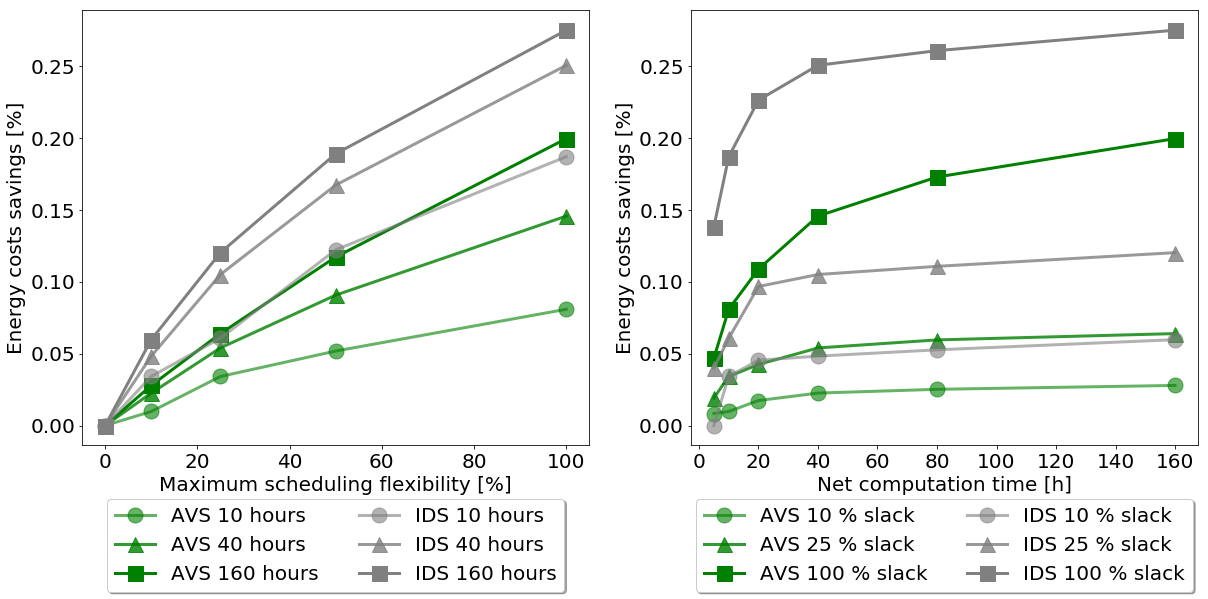

In [69]:
# generate a figure with two subplots
fig, axs = plt.subplots(1, 2,figsize =[20, 8])

slacks = results_mean["slack"].drop_duplicates().values * 100

# The first subplot shows the energy cost savings for differente net computation times by the amount of slack

# isolate the values for the x-axis transform to percent
slacks = results_mean["slack"].drop_duplicates().values * 100
# iterate through schedulers
for i in range(len(schedulers)):
    # iterate through net computation times to be plotted
    for j in range(len(net_time_plots)):
        label = "%s %i hours"%(schedulers[i], net_time_plots[j])
        # isolate y axis values
        cost_savings = results_mean[(results_mean["scheduler"] == schedulers[i]) &
                                    (results_mean["net_time"] == net_time_plots[j])]["cost_savings"].values
        axs[0].plot(slacks, cost_savings, net_time_styles[j],label=label, markersize=marker_size, linewidth=line_width,
                    color=scheduler_colors[i], alpha=net_time_alphas[j])

# labeling the axis and adding a legend
axs[0].set_ylabel("Energy costs savings [%]")
axs[0].set_xlabel("Maximum scheduling flexibility [%]")
lgd1 = axs[0].legend(fontsize=font_size,loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)
# adapt font sizes
for item in ([axs[0].title, axs[0].xaxis.label, axs[0].yaxis.label] +
             axs[0].get_xticklabels() + axs[0].get_yticklabels()):
    item.set_fontsize(font_size)
    
# The second subplot shows the energy cost savings for differente slack values by the net computation times  

# isolate the values for the x-axis transform to percent
net_times = results_mean["net_time"].drop_duplicates().values

# iterate through schedulers
for i in range(len(schedulers)):
    for j in range(len(slack_plots)):
        label = "%s %i %% slack" % (schedulers[i], (int(slack_plots[j] * 100)))
        # isolate y axis
        cost_savings = results_mean[(results_mean["scheduler"] == schedulers[i]) &
                                    (results_mean["slack"] == slack_plots[j])]["cost_savings"].values
        axs[1].plot(net_times, cost_savings, slack_styles[j],label=label, markersize=marker_size, linewidth=line_width,
                    color=scheduler_colors[i], alpha=slack_alphas[j])

# labeling the axis and adding a legend
axs[1].set_ylabel("Energy costs savings [%]")
axs[1].set_xlabel("Net computation time [h]")
lgd2 =axs[1].legend(fontsize = font_size,loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)
# adapt font sizes
for item in ([axs[1].title, axs[1].xaxis.label, axs[1].yaxis.label] +
             axs[1].get_xticklabels() + axs[1].get_yticklabels()):
    item.set_fontsize(font_size)
    
# show the plot
fig.show()

# uncomment line below to save the figure as jpg file
# fig.savefig("slack.jpg", bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')